## Hierarchical Bayesian Modeling to assess tribal knowledge

In this analysis, we will try to create a methodology and data-driven metric for identifying potential technological risks within an organization's coding protocols. We'll examine how programming languages are utilised across various projects and repositories, similar to those found in code repositories such as GitHub,  and leverage Hierarchical Bayesian Modelling (HBM) for multi-level data analysis. 

HBM effectively captures project-specific variances and overall project trends, providing a nuanced "risk" metric for Enterprise Architecture. This enables organisations to identify potential knowledge silos and make strategic decisions to enhance project continuity and organisational adaptability.

By analysing language usage across different organisational levels and integrating uncertainty, HBM aims to expose pockets of siloed tribal knowledge (in this example, via a proxy of languages used, but can easily be extended to accommodate other features such a #of commits, time since last commit, total commits, etc., etc.), which is crucial for identifying hidden risks within the architectural framework. This analysis uncovers potential vulnerabilities and compares language usage at repository and project scales against wider organisational patterns. These comparative insights are critical, revealing when a technology may seem insignificant in isolation emerges as a considerable risk in the broader organisational context due to limited expertise or exposure. This comprehensive examination ensures that technology decisions are made with a strategic perspective, reinforcing organisational resilience in the face of technological evolution.

For a more concrete example, consider a scenario where an organisation's repository primarily uses Haskell, a language not commonly used in broader enterprise contexts. Hierarchical Bayesian Modelling evaluates the risk by scrutinising Haskell's application within the repository, its relevance to the project, and its organisational prevalence. This comprehensive assessment ascertains the alignment of Haskell's use with the enterprise's technological trajectory and knowledge base, guiding strategic architectural decisions.


#### Flow
To start building a hierarchical Bayesian model using PyMC3 based on your JSON data, you'll first need to parse the data to extract the relevant information for modelling. This involves aggregating language usage across repositories and projects. After that, we define a hierarchical model that captures the variability within repositories and commonalities across projects.

* Data Preparation: Aggregate the language bytes for each language across all repositories and projects.
* Model Definition: Define a hierarchical model in Pymc, using project-level priors influencing repository-level distributions.
* Inference: Use MCMC provided by pymc to sample from the posterior distribution.
* Analysis: Analyze the posterior distributions to identify languages with usage outside the credible regions.

In [8]:
# Import required packages

import pandas as pd
import numpy as np
import pymc as pm
import graphviz
import arviz as az
import pprint

from utils import load_data, json2pandas


## Pre-Processing
The first step is to run the `generate_dummy_data.py` file to make sure we have data to play around with, the generated dummy data is similar to what you might pull from GitHub's REST API for repository languages https://docs.github.com/en/rest/repos/repos?apiVersion=2022-11-28#list-repository-languages

```GitHub CLI api
https://cli.github.com/manual/gh_api

gh api \
  -H "Accept: application/vnd.github+json" \
  -H "X-GitHub-Api-Version: 2022-11-28" \
  /repos/OWNER/REPO/languages

Example Response:
{
  "C": 78769,
  "Python": 7769
}
```



From here, we can load and transform the data. 

In [9]:
df_json = load_data("data/dummy_language_data.json")
# Prety print some Projects and Repos randomly to visualise the data
NUM_PROJECTS = 1
first_N_projects = {k: df_json[k] for k in list(df_json)[:NUM_PROJECTS]}
pp = pprint.PrettyPrinter(depth=3)
pp.pprint(first_N_projects)

{'Project_1': {'Repo_1': {'C#': 901416,
                          'Groovy': 2105,
                          'Java': 2105704,
                          'Kotlin': 814857,
                          'Lua': 15832,
                          'Rust': 311852,
                          'SQL': 592745},
               'Repo_10': {'Bash': 2315026,
                           'C#': 787532,
                           'Dart': 1660530,
                           'Kotlin': 870598,
                           'Rust': 229314},
               'Repo_11': {'C#': 2011185, 'Erlang': 4657070},
               'Repo_2': {'Bash': 414472,
                          'Elixir': 240387,
                          'Go': 407618,
                          'JavaScript': 312394,
                          'Kotlin': 646016,
                          'Python': 1692987,
                          'Rails': 59896,
                          'TypeScript': 173034},
               'Repo_3': {'Rust': 567407, 'Scala': 5777592},
            

Let's flip this into a normal dataset we are used to, and and a new variable to log transform the byte count.

In [10]:
df=json2pandas(df_json)
# Using pandas to calculate the logarithm of the ByteCount column
df['logByteCount'] = np.log(df['ByteCount'])
# Creating a new column Project_Repo by concatenating Project and Repository columns
df['Project_Repo'] = df['Project'] + "_" + df['Repository']

columns_to_encode = ['Project', 'Repository', 'Language', 'Project_Repo']

# Loop over the columns to encode
for column_name in columns_to_encode:
    # Cast each column to Categorical and add it as a new column with a suffix '_codes'
    df[f'{column_name}_codes'] = df[column_name].astype('category').cat.codes

    
print(df.head(n=20))
print("Total number of projects:", df['Project'].unique().shape)
print("Total number of projects repo ids:", df['Project_Repo_codes'].unique().shape)

      Project Repository    Language  ByteCount  logByteCount  \
0   Project_1     Repo_1        Java    2105704     14.560160   
1   Project_1     Repo_1         SQL     592745     13.292520   
2   Project_1     Repo_1      Groovy       2105      7.652071   
3   Project_1     Repo_1        Rust     311852     12.650284   
4   Project_1     Repo_1          C#     901416     13.711722   
5   Project_1     Repo_1         Lua      15832      9.669788   
6   Project_1     Repo_1      Kotlin     814857     13.610768   
7   Project_1     Repo_2        Bash     414472     12.934761   
8   Project_1     Repo_2      Kotlin     646016     13.378580   
9   Project_1     Repo_2      Python    1692987     14.342005   
10  Project_1     Repo_2       Rails      59896     11.000365   
11  Project_1     Repo_2      Elixir     240387     12.390005   
12  Project_1     Repo_2          Go     407618     12.918086   
13  Project_1     Repo_2  JavaScript     312394     12.652020   
14  Project_1     Repo_2 

## Hierarchical Model Specification

This section introduces Hierarchical Bayesian Modelling (HBM) principles and their application in structuring complex, multi-level datasets, such as those encountered in evaluating technological risks within coding languages.

#### Introduction to Hierarchical Bayesian Modelling
Hierarchical Bayesian Modelling is a statistical framework that enables data analysis across different levels of hierarchy by integrating the variability within individual units (such as repositories) and the commonalities across groups (such as projects, domains, or departments). Bayes' theorem is at the core of Bayesian inference, which updates the probability for a hypothesis as more evidence becomes available. One of the critical concepts in HBM is exchangeability, which implies that data points are probabilistically symmetrical. This makes it suitable for modelling data that doesn't have a natural ordering or grouping but is considered identically distributed given some unknown parameters.

When we analyse the usage of programming languages, we're looking at a hierarchical model structure with multiple layers. Given that the `ByteCount` variable represents the number of bytes of code for a given language in a repository, it essentially counts data (albeit at a potentially large scale that we might want to log-transform later). Count data is often modelled using distributions specifically suited to non-negative integer values, such as the Negative Binomial, leading us to represent our model as a Hierarchical Beta-Negative Binomial Model.

These layers represent language usage within repositories, which are nested within projects.

- **Level 1 - Repository-Level Likelihood:** At this level, we describe the observed data, such as the amount of code written in each language within a repository, using a likelihood function.

  $$ P(Language_{ij} | \theta_{ij}) \sim NegativeBinomial(\mu_{ij}, \alpha) $$

  Here, \( \theta_{ij} \) represents the expected byte count for language usage, where \( i \) denotes the repository and \( j \) the language. \( \mu_{ij} \) is the mean parameter and \( \alpha \) is the dispersion parameter of the Negative Binomial distribution.

- **Level 2 - Project-Level Priors:** As we move up to the project level, parameters from the repository level are considered uncertain and are described by priors.

  $$ \mu_{ij} | \mu_i, \kappa_i \sim Beta(\mu_i \kappa_i, (1 - \mu_i) \kappa_i) $$

  The Beta distribution parameters \( \mu_i \) and \( \kappa_i \) represent the expected language usage and variability within a project, influencing the mean parameter \( \mu_{ij} \) of the Negative Binomial distribution at the repository level.

- **Level 3 - Organisational-Level Hyperpriors:** At the organisational level, we look at the broader patterns in language usage across all projects.

  $$ \mu_i \sim Beta(a_{\mu}, b_{\mu}) $$
  $$ \kappa_i \sim Gamma(a_{\kappa}, b_{\kappa}) $$

  Hyperpriors for \( \mu_i \) and \( \kappa_i \) reflect our assumptions about these patterns before analysing the data.

This hierarchical approach allows for a detailed analysis of organisational language usage. We're not just modelling individual repositories but also capturing trends across projects and the entire organisation.

#### Explanation of Model Parameters and Priors

Hierarchical Bayesian Modelling (HBM) views parameters as distributions, known as priors. Priors represent our initial beliefs or understanding about the parameters before examining the data. When dealing with count data, such as the count of bytes of code in different programming languages within repositories, overdispersion is often observed in such data. A Negative Binomial distribution can account for this overdispersion.

The model includes hyperparameters, such as the mean parameter  \($ \mu $\)  for the Negative Binomial distribution. These hyperparameters introduce a layer of variability accounting for differences within repositories and across projects. Moreover, these hyperparameters are informed by higher-level distributions, or hyperpriors. For example, a Beta distribution might be used to model project-level variability, influencing the Negative Binomial's mean parameter \( $\mu $\), while a Gamma distribution is applied to the dispersion parameter \($ \alpha $\), relating to the variability of byte counts.

Employing this type of hierarchical model enables the refinement of our initial beliefs in light of collected data, leading to a deeper and more nuanced understanding of an organisation's coding practices. The adaptability of this model to new information enhances the precision of our insights, effectively capturing both the average and the variance of language usage within the complex hierarchical structure of repositories and projects.



## Transitioning to Posterior Distributions

### From Theory to Practice: The Role of Posterior Distributions

With our model parameters defined and their priors set, the next step in Bayesian analysis is to update these beliefs with observed data. This is where the posterior distribution comes into play.


#### What is the posterior?

In the hierarchical Bayesian modelling (HBM) context, the posterior distribution is the updated belief about our model's parameters after considering the observed data. It combines our prior beliefs (the priors) and the evidence from the data (the likelihood). Mathematically, it is expressed as:

$$
P(\theta | data) \propto P(data | \theta) \times P(\theta)
$$

Where:
- \($ P(\theta | data) $\) is the posterior distribution of the parameters \($ \theta $\).
- \($ P(data | \theta) $\) is the likelihood of the data given the parameters.
- \($ P(\theta) $\) is the prior distribution of the parameters.

After observing the data, the posterior distribution provides a range of likely values for the parameters, which is crucial for making informed decisions.


### Practical Implications of Posterior Analysis in Hierarchical Bayesian Modelling

Through the lens of Hierarchical Bayesian Modelling, the posterior distribution becomes a beacon, illuminating the path to understanding and action within an organisation's coding practices.


### Informing Strategic Decision-Making

The power of posterior analysis extends beyond diagnostics; it informs strategic resource allocation and risk management:

- **Credible Intervals**: The precision of parameter estimates, reflected in the credible intervals of the posterior distribution, directs our focus to areas where additional data collection or deeper investigation may be warranted.

- **Outlier Detection**: Spotting outliers within posterior distributions alerts us to unconventional language usage patterns. These could represent areas of innovation warranting further exploration or potential risks if the languages in question lack broad support.

- **Strategic Resource Allocation**: Insights gained from posterior distributions enable informed decisions on resource allocation—be it for targeted training programmes, strategic hiring to build expertise in underutilised languages, or investment in technology stacks that promise to align with and propel the organisation's strategic objectives.

Interpreting the posterior distributions derived from our hierarchical model does more than just enhance our understanding of language usage; it equips us to forecast, plan, and foster a coding environment that is both efficient and resilient to future challenges.

### Uncovering Knowledge Silos

The posterior distributions for language usage within repositories serve as a diagnostic tool, revealing languages that are disproportionately relied upon. Anomalies in these distributions may signal the existence of knowledge silos, suggesting areas where diversification and training could be beneficial. By identifying these silos, we can proactively address potential bottlenecks in knowledge transfer and code maintenance.

### Assessing Project-Level Variability

The consistency of coding practices across repositories within projects is characterised by project-level hyperparameters. When significant variability is observed in these posterior distributions, it may reflect fragmented coding practices that could undermine team collaboration and project efficiency. This insight drives us to review and possibly revise coding standards, ensuring that practices are aligned and conducive to project success.

### Evaluating Organisational Coding Norms

At the highest organisational level, posterior distributions offer a macro perspective of coding culture and norms. Deviations in these distributions can reveal organisational preferences or aversions towards specific languages. Understanding these trends is critical for shaping future strategies in technology adoption, capability development, and training initiatives.


## Model Implementation
- Implementing the HBM using PyMC3
- Defining the model in PyMC3
- Setting up the priors for each level of the hierarchy
- Incorporating the data into the model
- Model fitting (e.g., using MCMC methods)

In [11]:
# Assuming 'df' is your DataFrame and necessary imports are done
n_projects = df['Project_codes'].nunique()
n_repos = df['Repository_codes'].nunique()
n_project_repos = df['Project_Repo_codes'].nunique()
n_languages = df['Language_codes'].nunique()

# Calculate average byte count per language as a starting point
avg_byte_per_language = df.groupby('Language_codes')['ByteCount'].mean().reset_index()
avg_byte_per_language['logByte'] = np.log(avg_byte_per_language['ByteCount'])

# Calculate average byte count per project
avg_byte_per_project = df.groupby('Project_codes')['ByteCount'].mean().reset_index()
avg_byte_per_project['logByte'] = np.log(avg_byte_per_project['ByteCount'])

# Calculate average byte count per repository
avg_byte_per_repo = df.groupby('Repository_codes')['ByteCount'].mean().reset_index()
avg_byte_per_repo['logByte'] = np.log(avg_byte_per_repo['ByteCount'])

# Calculate average byte count per project per repository
avg_byte_per_projrepo = df.groupby('Project_Repo_codes')['ByteCount'].mean().reset_index()
avg_byte_per_projrepo['logByte'] = np.log(avg_byte_per_projrepo['ByteCount'])

project_idx = df['Project_codes'].values
repo_idx = df['Repository_codes'].values
languages_idx = df['Language_codes'].values
byte_count = df['ByteCount'].values

# Outside the model, verify shapes and values directly in Python
print(f'n_languages: {n_languages}, n_projects: {n_projects}, n_repos: {n_repos}')
print(f'avg_byte_per_language: {avg_byte_per_language.head(5)}\n',  
      f'avg_byte_per_project: {avg_byte_per_project.head(5)}\n', 
      f'avg_byte_per_repo: {avg_byte_per_repo.head(5)}\n', 
      f'avg_byte_per_projrepo: {avg_byte_per_projrepo.head(5)}\n\n')
print(f'project_idx shape: {project_idx.shape}, repo_idx shape: {repo_idx.shape}, languages_idx shape: {languages_idx.shape}')


n_languages: 37, n_projects: 40, n_repos: 15
avg_byte_per_language:    Language_codes     ByteCount    logByte
0               0  1.014471e+06  13.829878
1               1  1.615548e+06  14.295185
2               2  1.407680e+06  14.157453
3               3  1.466691e+06  14.198520
4               4  1.012108e+06  13.827546
 avg_byte_per_project:    Project_codes     ByteCount    logByte
0              0  1.013978e+06  13.829391
1              1  1.306852e+06  14.083132
2              2  8.610294e+05  13.665884
3              3  1.139761e+06  13.946329
4              4  1.219516e+06  14.013964
 avg_byte_per_repo:    Repository_codes     ByteCount    logByte
0                 0  1.479278e+06  14.207065
1                 1  1.389882e+06  14.144729
2                 2  1.301123e+06  14.078738
3                 3  1.006541e+06  13.822030
4                 4  1.401065e+06  14.152743
 avg_byte_per_projrepo:    Project_Repo_codes     ByteCount    logByte
0                   0  2.465840e+06  1

In [12]:
import pytensor

# Example of setting a PyTensor configuration option for debugging
pytensor.config.exception_verbosity = 'high'

# Build the model
with pm.Model() as language_usage_model:
    # Define organisational-level hyperpriors that influence project-level parameters
    # These represent our assumptions about the variability across all projects
    a_mu = pm.Gamma('a_mu', alpha=1.0, beta=1.0, initval=2.0)
    b_mu = pm.Gamma('b_mu', alpha=1.0, beta=1.0, initval=2.0)
    a_kappa = pm.Gamma('a_kappa', alpha=1.0, beta=0.1, initval=2.0)
    b_kappa = pm.Gamma('b_kappa', alpha=1.0, beta=0.1, initval=2.0)

    # Language-Level Priors
    # Assuming each language has an associated effect on the byte counts
    language_effect = pm.Normal('language_effect', mu=0, sigma=1, shape=n_languages)
    
    # Define project-level priors that capture the mean and variability of language usage within each project
    # 'mu_project' represents the expected proportion of language usage within projects
    # 'kappa_project' captures the variability of language usage within projects
    mu_project = pm.Beta('mu_project', alpha=a_mu, beta=b_mu, shape=n_projects)
    kappa_project = pm.Gamma('kappa_project', alpha=a_kappa, beta=b_kappa, shape=n_projects)
    
    
    # Define repository-level effects influenced by their respective projects 'theta_repo' represents the expected
    # Proportion of language usage within each repository, influenced by the project to which it belongs.
    theta_repo = pm.Beta('theta_repo', alpha=mu_project[project_idx] * kappa_project[project_idx], 
                         beta=(1 - mu_project[project_idx]) * kappa_project[project_idx], 
                         shape=n_repos)
    
    # Repository-Level Likelihood adjusted for language effect
    # Here, we assume that the byte counts are influenced by both the repository effect and the language effect
    mu_repo_lang = theta_repo[repo_idx] + language_effect[languages_idx]
        
    # Define the dispersion parameter for the Negative Binomial distribution to account for overdispersion in the byte counts 'dispersion_factor' controls the variance of the
    # Negative Binomial distribution independently from the mean
    dispersion_factor = pm.Exponential('dispersion_factor', lam=1.0)
     # The Negative Binomial distribution models the observed byte counts, now influenced by both repository and language effects
    language_count = pm.NegativeBinomial('language_count', mu=mu_repo_lang, alpha=dispersion_factor, observed=byte_count)


Here’s the graphical representation of the model.

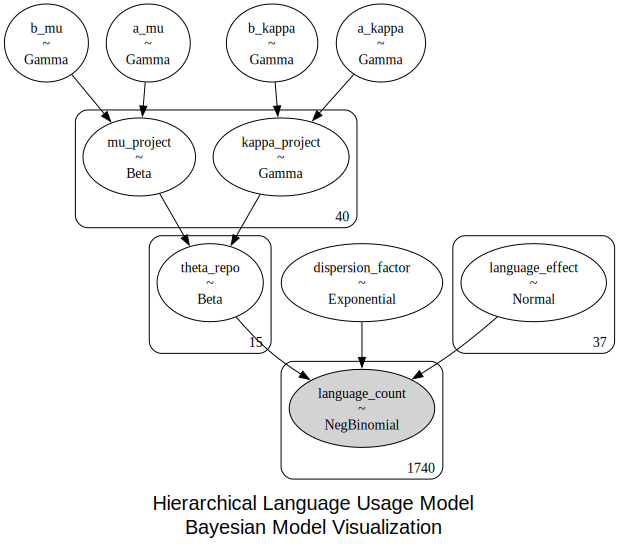

In [13]:
# Assuming 'language_usage_model' is your PyMC model
model_graph = pm.model_to_graphviz(language_usage_model)

# Customize the graph - Example changes
model_graph.attr(label='Hierarchical Language Usage Model\nBayesian Model Visualization')
model_graph.attr(fontsize='20', color='blue', fontname="Helvetica")

# Node and Edge customizations
with model_graph.subgraph() as s:
    s.attr(rank='same')
    # Customize nodes
    s.node_attr.update(color='lightblue2', style='filled', fontname="Helvetica")
    # Customize edges
    s.edge_attr.update(color='gray', arrowsize='0.5')

# Render the graph 
model_graph


In [14]:
# Fiting the model with MCMC
with language_usage_model:
    trace = pm.sample(1000, tune=500, return_inferencedata=True)

C:\Users\VCB\AppData\Local\pypoetry\Cache\virtualenvs\tribal-knowledge-tLBhIDXi-py3.11\Lib\site-packages\pytensor\tensor\rewriting\shape.py:158: UserWarning: Failed to infer_shape from Op Mul.
Input shapes: [(TensorConstant(TensorType(int64, shape=()), data=array(15, ... ype=int64)),), (TensorConstant(TensorType(int64, shape=()), data=array(1740 ... ype=int64)),)]
Exception encountered during infer_shape: <class 'ValueError'>
Exception message: Could not broadcast dimensions. Incompatible shapes were [(TensorConstant(TensorType(int64, shape=()), data=array(15, ... ype=int64)),), (TensorConstant(TensorType(int64, shape=()), data=array(1740 ... ype=int64)),)].
Traceback: Traceback (most recent call last):
  File "C:\Users\VCB\AppData\Local\pypoetry\Cache\virtualenvs\tribal-knowledge-tLBhIDXi-py3.11\Lib\site-packages\pytensor\tensor\rewriting\shape.py", line 134, in get_node_infer_shape
    o_shapes = shape_infer(
               ^^^^^^^^^^^^
  File "C:\Users\VCB\AppData\Local\pypoetry\Cac

AssertionError: SpecifyShape: Got shape (1740,), expected (15,).
Apply node that caused the error: SpecifyShape(AdvancedSubtensor.0, 15)
Toposort index: 19
Inputs types: [TensorType(float64, shape=(None,)), TensorType(int8, shape=())]
Inputs shapes: [(1740,), ()]
Inputs strides: [(8,), ()]
Inputs values: ['not shown', array(15, dtype=int8)]
Inputs type_num: [12, 1]
Outputs clients: [[Mul(SpecifyShape.0, AdvancedSubtensor.0)]]

Debug print of the apply node: 
SpecifyShape [id A] <Vector(float64, shape=(15,))>
 ├─ AdvancedSubtensor [id B] <Vector(float64, shape=(?,))>
 │  ├─ Alloc [id C] <Vector(float64, shape=(40,))>
 │  │  ├─ 0.5 [id D] <Scalar(float64, shape=())>
 │  │  └─ 40 [id E] <Scalar(int64, shape=())>
 │  └─ [ 0  0  0 ... 34 34 34] [id F] <Vector(int8, shape=(1740,))>
 └─ 15 [id G] <Scalar(int8, shape=())>

HINT: Re-running with most PyTensor optimizations disabled could provide a back-trace showing when this node was created. This can be done by setting the PyTensor flag 'optimizer=fast_compile'. If that does not work, PyTensor optimizations can be disabled with 'optimizer=None'.
HINT: Use the PyTensor flag `exception_verbosity=high` for a debug print-out and storage map footprint of this Apply node.

## Model Diagnostics
 - Checking model convergence (e.g., trace plots, R-hat statistics)
Posterior predictive checks


In [15]:
# Summary statistics for the posterior distributions
summary = az.summary(trace)

# Trace plots for parameter exploration
az.plot_trace(trace)

# Model diagnostics (e.g., effective sample size, R-hat)
diagnostics = az.rhat(trace)


NameError: name 'trace' is not defined

##  Results and Interpretation
- Extracting and summarizing the posterior distributions of model parameters
- Identifying significant factors and their impacts on language usage risk metrics
- Ridge plots for visualizing the distribution of language usage across projects and repositories, highlighting potential outliers or risks
- Additional plots for deeper insights (e.g., comparison of language usage trends across different organizational levels)

#### Key Considerations:

- **Credible Intervals and Outliers**: Narrow credible intervals suggest high parameter estimate certainty, while wide intervals indicate areas needing further investigation. Outlier detection can pinpoint innovative areas or non-standard practices for strategic exploration.

- **Decision-Making**: Insights from the HBM should inform strategic decisions regarding technology adoption, project management, and training to align coding practices with organizational goals, enhancing project continuity and adaptability.

This combined understanding of HBM principles, model structure, and practical implications equips readers with the knowledge to interpret complex data analyses meaningfully, driving informed decision-making within the organisation.

## Streamlit app